# Notebook 03 — Feature Engineering & Baseline Models (LogReg / RF / XGBoost)

## Step 1 — Imports, paths, and config

In [1]:
# %%
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from xgboost import XGBClassifier

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
sns.set(style="whitegrid")

RANDOM_SEED = 42

PATIENT_COL = "Patient_ID"
TIME_COL = "ICULOS"
TARGET_COL = "SepsisLabel"
LABEL_COL = "Label_6h"


def find_project_root() -> Path:
    cur = Path.cwd().resolve()
    for candidate in [cur, *cur.parents]:
        if (candidate / "notebooks").exists() and (candidate / "reports").exists():
            return candidate
    return cur


PROJECT_ROOT = find_project_root()
REPORTS_ROOT = PROJECT_ROOT / "reports"

RESULTS_LABELING = REPORTS_ROOT / "results" / "02_labeling_eda"
RESULTS_THIS = REPORTS_ROOT / "results" / "03_feature_engineering_baselines"
FIGURES_THIS = REPORTS_ROOT / "figures" / "03_feature_engineering_baselines"

RESULTS_THIS.mkdir(parents=True, exist_ok=True)
FIGURES_THIS.mkdir(parents=True, exist_ok=True)

EXPORTED_FIGURES = []

print("cwd:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("Labeling results dir:", RESULTS_LABELING)
print("This notebook results dir:", RESULTS_THIS)
print("This notebook figures dir:", FIGURES_THIS)

cwd: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\notebooks
PROJECT_ROOT: C:\Users\marta\PyCharmMiscProject\sepsis-predictor
Labeling results dir: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda
This notebook results dir: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\03_feature_engineering_baselines
This notebook figures dir: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\03_feature_engineering_baselines


## Step 2 — Load labeled datasets (from Notebook 02)

In [2]:
train_path = RESULTS_LABELING / "02_labeling_eda_train.csv"
test_path = RESULTS_LABELING / "02_labeling_eda_test.csv"
full_path = RESULTS_LABELING / "02_labeling_eda_full.csv"

print("Loading labeled datasets from:")
print("  train:", train_path)
print("  test :", test_path)
print("  full :", full_path)

assert train_path.exists(), f"Missing file: {train_path}"
assert test_path.exists(), f"Missing file: {test_path}"
assert full_path.exists(), f"Missing file: {full_path}"

train_df = pd.read_csv(train_path, low_memory=False)
test_df = pd.read_csv(test_path, low_memory=False)
full_df = pd.read_csv(full_path, low_memory=False)

for name, df in [("train_df", train_df), ("test_df", test_df), ("full_df", full_df)]:
    assert df.columns.is_unique, f"Duplicate column names in {name}"

print("\nLoaded datasets:")
print("  train_df:", train_df.shape)
print("  test_df :", test_df.shape)
print("  full_df :", full_df.shape)
display(train_df.head())

Loading labeled datasets from:
  train: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_labeling_eda_train.csv
  test : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_labeling_eda_test.csv
  full : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_labeling_eda_full.csv

Loaded datasets:
  train_df: (1220925, 19)
  test_df : (306301, 19)
  full_df : (1527226, 19)


,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,sepsis_onset_time,Label_6h
0,-0.981406,0.738859,-0.890076,-1.095866,-1.132851,-0.464943,-0.139349,0.068645,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,1,0,1,NaN,0
1,-0.942007,0.738859,-0.890076,-1.095866,-1.132851,-0.464943,-0.139349,0.068645,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,2,0,1,NaN,0
2,-0.902609,0.269532,0.700883,-1.095866,-0.070135,0.216319,-0.139349,0.684351,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,3,0,1,NaN,0
3,-0.863210,0.328198,-0.890076,-1.095866,-0.070135,0.216319,-0.139349,2.326236,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,4,0,1,NaN,0
4,-0.823812,1.090853,-3.276514,-1.095866,-0.070135,0.556631,-0.139349,1.197440,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,5,0,1,NaN,0


## Step 3 — Schema and label sanity checks

In [3]:
expected_cols = list(train_df.columns)

# Column presence + order
for name, df in [("test_df", test_df), ("full_df", full_df)]:
    assert list(df.columns) == expected_cols, f"{name} columns differ from train_df"

# Key columns present
for df_name, df in [("train_df", train_df), ("test_df", test_df), ("full_df", full_df)]:
    for col in [PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL, "sepsis_onset_time"]:
        assert col in df.columns, f"{col} missing in {df_name}"

    assert df[LABEL_COL].isin([0, 1]).all(), (
        f"{df_name}: {LABEL_COL} has values other than 0/1"
    )
    assert df[LABEL_COL].isna().sum() == 0, (
        f"{df_name}: {LABEL_COL} contains NaNs"
    )

# Align dtypes of test/full to train_df where safely possible
def align_dtypes(reference: pd.DataFrame, other: pd.DataFrame, other_name: str) -> None:
    for col, ref_dtype in reference.dtypes.items():
        other_dtype = other[col].dtype
        if other_dtype == ref_dtype:
            continue

        if np.issubdtype(ref_dtype, np.number) and np.issubdtype(other_dtype, np.number):
            print(
                f"Aligning dtype for column '{col}' in {other_name}: "
                f"{other_dtype} -> {ref_dtype}"
            )
            other[col] = other[col].astype(ref_dtype)
            continue

        raise AssertionError(
            f"Dtype mismatch for column '{col}' between train_df ({ref_dtype}) "
            f"and {other_name} ({other_dtype}) that cannot be safely aligned."
        )


align_dtypes(train_df, test_df, "test_df")
align_dtypes(train_df, full_df, "full_df")

print("\nBasic schema checks passed.")


Basic schema checks passed.


## Step 4 — Define modeling cohort and history window

In [4]:
WINDOW_HOURS = 6  # length of history window used to build features

print(f"Using a {WINDOW_HOURS}-hour history window for feature engineering.")

# Ensure all frames are sorted by patient and time, and add an index per patient
for name, df in [("train_df", train_df), ("test_df", test_df)]:
    df.sort_values([PATIENT_COL, TIME_COL], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df["hour_index"] = df.groupby(PATIENT_COL).cumcount()
    print(f"{name}: rows={df.shape[0]}, patients={df[PATIENT_COL].nunique()}")


Using a 6-hour history window for feature engineering.
train_df: rows=1220925, patients=32268
test_df: rows=306301, patients=8068


## Step 5 — Time-window feature engineering (rolling means and slopes)

In [5]:
EXCLUDE_BASE_COLS = {
    PATIENT_COL,
    TIME_COL,
    TARGET_COL,
    LABEL_COL,
    "sepsis_onset_time",
    "hour_index",
}

numeric_cols = [
    c for c in train_df.columns
    if c not in EXCLUDE_BASE_COLS and pd.api.types.is_numeric_dtype(train_df[c])
]

print(f"Number of numeric feature columns (before windowing): {len(numeric_cols)}")


def add_window_features(
    df: pd.DataFrame,
    feature_cols: list[str],
    window_hours: int,
) -> pd.DataFrame:
    df_out = df.copy()
    grouped = df_out.groupby(PATIENT_COL, group_keys=False)

    for col in feature_cols:
        roll = grouped[col].rolling(window_hours, min_periods=window_hours)

        mean_feat = roll.mean().reset_index(level=0, drop=True)
        df_out[f"{col}_mean_{window_hours}h"] = mean_feat

        first_in_window = grouped[col].shift(window_hours - 1)
        df_out[f"{col}_slope_{window_hours}h"] = (
            df_out[col] - first_in_window
        ) / (window_hours - 1)

    return df_out


print("Adding window features to train/test...")
train_df_win = add_window_features(train_df, numeric_cols, WINDOW_HOURS)
test_df_win = add_window_features(test_df, numeric_cols, WINDOW_HOURS)

print("Shapes with window features:")
print("  train_df_win:", train_df_win.shape)
print("  test_df_win :", test_df_win.shape)


Number of numeric feature columns (before windowing): 14
Adding window features to train/test...
Shapes with window features:
  train_df_win: (1220925, 48)
  test_df_win : (306301, 48)


## Step 6 — Build modeling cohort (only rows with full history window)

In [6]:
def build_modeling_cohort(df_with_win: pd.DataFrame, window_hours: int) -> pd.DataFrame:
    mask = df_with_win["hour_index"] >= (window_hours - 1)
    cohort = df_with_win.loc[mask].reset_index(drop=True)
    return cohort


train_model_df = build_modeling_cohort(train_df_win, WINDOW_HOURS)
test_model_df = build_modeling_cohort(test_df_win, WINDOW_HOURS)

print("Modeling cohorts (rows with full history window):")
print("  train_model_df:", train_model_df.shape)
print("  test_model_df :", test_model_df.shape)

print("\nPatients retained after windowing:")
print("  train patients:", train_model_df[PATIENT_COL].nunique())
print("  test patients :", test_model_df[PATIENT_COL].nunique())

display(train_model_df[[PATIENT_COL, TIME_COL, LABEL_COL]].head())


Modeling cohorts (rows with full history window):
  train_model_df: (1061297, 48)
  test_model_df : (266361, 48)

Patients retained after windowing:
  train patients: 31731
  test patients : 7937


,Patient_ID,ICULOS,Label_6h
0,1,6,0
1,1,7,0
2,1,8,0
3,1,9,0
4,1,10,0


## Step 7 — Build feature matrix (X) and target vector (y)

In [7]:
FEATURE_EXCLUDE = {
    PATIENT_COL,
    TIME_COL,
    TARGET_COL,
    LABEL_COL,
    "sepsis_onset_time",
    "hour_index",
}

feature_cols = [
    c for c in train_model_df.columns
    if c not in FEATURE_EXCLUDE and pd.api.types.is_numeric_dtype(train_model_df[c])
]

print(f"Number of feature columns (after windowing): {len(feature_cols)}")
print("Sample features:", feature_cols[:10])

X_train_full = train_model_df[feature_cols].copy()
y_train_full = train_model_df[LABEL_COL].values

X_test = test_model_df[feature_cols].copy()
y_test = test_model_df[LABEL_COL].values

print("\nShapes of model matrices:")
print("  X_train_full:", X_train_full.shape)
print("  y_train_full:", y_train_full.shape)
print("  X_test      :", X_test.shape)
print("  y_test      :", y_test.shape)

Number of feature columns (after windowing): 42
Sample features: ['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Glucose', 'Age']

Shapes of model matrices:
  X_train_full: (1061297, 42)
  y_train_full: (1061297,)
  X_test      : (266361, 42)
  y_test      : (266361,)


## Step 8 — Patient-level train/validation split

In [8]:
# Patient-level label: does this patient ever have Label_6h == 1?
patient_level_train = (
    train_model_df
    .groupby(PATIENT_COL)[LABEL_COL]
    .max()
    .reset_index()
    .rename(columns={LABEL_COL: "any_pos_6h"})
)

patient_ids = patient_level_train[PATIENT_COL].values
patient_labels = patient_level_train["any_pos_6h"].values

print("Total train patients (after windowing):", len(patient_ids))
print("Patients with any positive 6h label:", patient_labels.sum(),
      f"({patient_labels.mean():.3%})")

train_ids, val_ids = train_test_split(
    patient_ids,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=patient_labels,
)

print("\nSplit sizes (patients):")
print("  train_ids:", len(train_ids))
print("  val_ids  :", len(val_ids))

# Map back to row-level cohorts
train_mask_inner = train_model_df[PATIENT_COL].isin(train_ids)
val_mask = train_model_df[PATIENT_COL].isin(val_ids)

X_train = X_train_full.loc[train_mask_inner].reset_index(drop=True)
y_train = y_train_full[train_mask_inner]

X_val = X_train_full.loc[val_mask].reset_index(drop=True)
y_val = y_train_full[val_mask]

print("\nRow-level shapes after patient-level split:")
print("  X_train:", X_train.shape, "  y_train:", y_train.shape)
print("  X_val  :", X_val.shape,   "  y_val  :", y_val.shape)

# Quick sanity check on label prevalence in each split
def print_label_stats(name, y):
    unique, counts = np.unique(y, return_counts=True)
    freq = dict(zip(unique, counts))
    total = len(y)
    print(f"{name}: n={total}, positives={freq.get(1, 0)} "
          f"({freq.get(1, 0) / total:.3%})")


print("\nLabel_6h prevalence by split:")
print_label_stats("TRAIN", y_train)
print_label_stats("VAL  ", y_val)
print_label_stats("TEST ", y_test)

Total train patients (after windowing): 31731
Patients with any positive 6h label: 1789 (5.638%)

Split sizes (patients):
  train_ids: 25384
  val_ids  : 6347

Row-level shapes after patient-level split:
  X_train: (848502, 42)   y_train: (848502,)
  X_val  : (212795, 42)   y_val  : (212795,)

Label_6h prevalence by split:
TRAIN: n=848502, positives=8127 (0.958%)
VAL  : n=212795, positives=2031 (0.954%)
TEST : n=266361, positives=2347 (0.881%)


## Step 9 — Baseline model: Logistic Regression

In [9]:
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",  # important due to heavy imbalance
        random_state=RANDOM_SEED,
        n_jobs=-1,
    )),
])

print("Training logistic regression baseline...")
logreg_pipeline.fit(X_train, y_train)

print("Model trained.")

Training logistic regression baseline...
Model trained.


### Evaluate on validation and test sets

In [10]:
def evaluate_model(model, X, y, split_name: str):
    probs = model.predict_proba(X)[:, 1]
    preds = model.predict(X)

    auroc = metrics.roc_auc_score(y, probs)
    precision, recall, _ = metrics.precision_recall_curve(y, probs)
    auprc = metrics.average_precision_score(y, probs)
    f1 = metrics.f1_score(y, preds)
    acc = metrics.accuracy_score(y, preds)

    print(f"\n[{split_name}]")
    print(f"AUROC: {auroc:.4f}")
    print(f"AUPRC: {auprc:.4f}")
    print(f"F1   : {f1:.4f}")
    print(f"ACC  : {acc:.4f}")

    return {
        "split": split_name,
        "auroc": auroc,
        "auprc": auprc,
        "f1": f1,
        "acc": acc,
        "probs": probs,
    }


results_val = evaluate_model(logreg_pipeline, X_val, y_val, "VAL")
results_test = evaluate_model(logreg_pipeline, X_test, y_test, "TEST")



[VAL]
AUROC: 0.7591
AUPRC: 0.0456
F1   : 0.0509
ACC  : 0.7793

[TEST]
AUROC: 0.7638
AUPRC: 0.0424
F1   : 0.0491
ACC  : 0.7838


### Plot ROC and PR curves

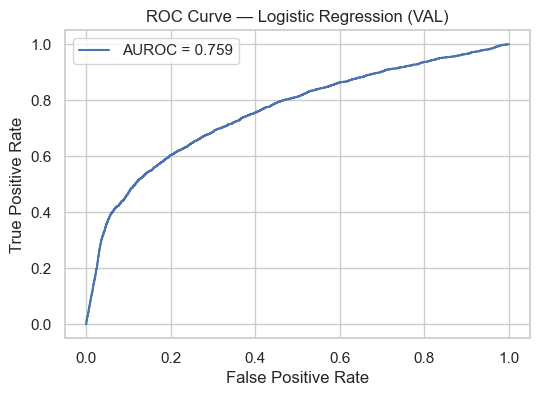

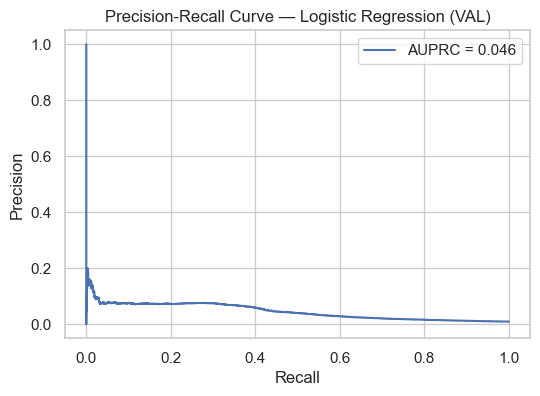

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
fpr, tpr, _ = metrics.roc_curve(y_val, results_val["probs"])
ax.plot(fpr, tpr, label=f"AUROC = {results_val['auroc']:.3f}")
ax.set_title("ROC Curve — Logistic Regression (VAL)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
EXPORTED_FIGURES.append(("03_logreg_roc_val", fig))
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = metrics.precision_recall_curve(y_val, results_val["probs"])
ax.plot(recall, precision, label=f"AUPRC = {results_val['auprc']:.3f}")
ax.set_title("Precision-Recall Curve — Logistic Regression (VAL)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
EXPORTED_FIGURES.append(("03_logreg_pr_val", fig))
plt.show()


The logistic regression baseline demonstrates moderately strong ranking
performance (AUROC = 0.759), indicating the model can distinguish patients
who will develop sepsis within 6 hours from those who will not. However,
the highly imbalanced nature of the dataset makes AUPRC a more informative
metric. The obtained AUPRC of 0.046 is approximately 5 times higher than
the random baseline (~0.009), confirming that the model captures clinically
meaningful predictive signal despite its simplicity.

## Step 10 — Baseline model: Random Forest

In [12]:
rf_pipeline = Pipeline([
    # No scaler needed for trees, but we keep a Pipeline for symmetry
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=5,
        n_jobs=-1,
        class_weight="balanced_subsample",
        random_state=RANDOM_SEED,
    )),
])

print("Training random forest baseline...")
rf_pipeline.fit(X_train, y_train)
print("Random forest trained.")

Training random forest baseline...
Random forest trained.


### Random Forest evaluation (VAL + TEST)

In [13]:
rf_results_val = evaluate_model(rf_pipeline, X_val, y_val, "VAL")
rf_results_test = evaluate_model(rf_pipeline, X_test, y_test, "TEST")


[VAL]
AUROC: 0.7700
AUPRC: 0.0490
F1   : 0.0000
ACC  : 0.9905

[TEST]
AUROC: 0.7925
AUPRC: 0.0443
F1   : 0.0000
ACC  : 0.9912


### ROC & PR curves for Random Forest (VAL)

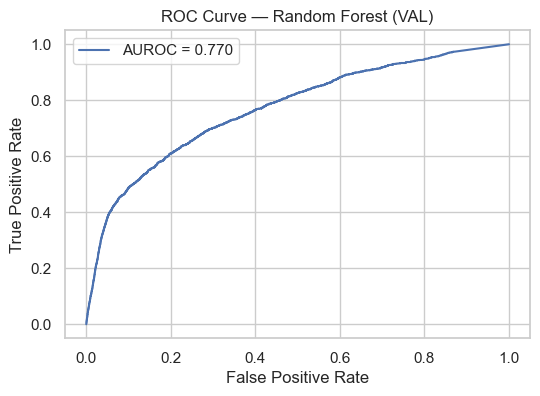

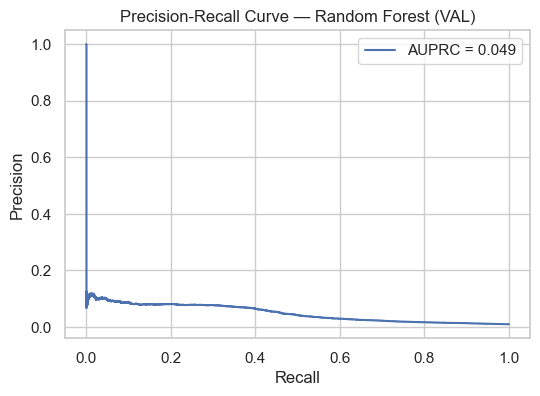

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_val, rf_results_val["probs"])
ax.plot(fpr_rf, tpr_rf, label=f"AUROC = {rf_results_val['auroc']:.3f}")
ax.set_title("ROC Curve — Random Forest (VAL)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
EXPORTED_FIGURES.append(("03_rf_roc_val", fig))
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
precision_rf, recall_rf, _ = metrics.precision_recall_curve(y_val, rf_results_val["probs"])
ax.plot(recall_rf, precision_rf, label=f"AUPRC = {rf_results_val['auprc']:.3f}")
ax.set_title("Precision-Recall Curve — Random Forest (VAL)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
EXPORTED_FIGURES.append(("03_rf_pr_val", fig))
plt.show()

Random Forest outperforms logistic regression in AUROC (0.770 vs 0.759),
indicating stronger ranking ability and better modeling of nonlinear
interactions between vitals and laboratory values. The improvement in
AUPRC is smaller (0.049 vs 0.046), which is expected given the extreme
class imbalance and the fact that both baselines were evaluated at the
default probability threshold. The F1 score remains at zero because the
model rarely predicts positives at this stage; threshold tuning will
be addressed in later notebooks. Overall, Random Forest confirms that
the current feature engineering is meaningful and provides a stronger
starting point for boosting-based models.


## Step 11 — Baseline model: XGBoost (gradient boosting)

In [15]:
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
pos_weight = n_neg / n_pos
print(f"XGBoost scale_pos_weight (neg/pos) = {pos_weight:.1f}")

xgb_model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=pos_weight,
    tree_method="hist",
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

print("Training XGBoost baseline...")
xgb_model.fit(X_train, y_train)
print("XGBoost trained.")


XGBoost scale_pos_weight (neg/pos) = 103.4
Training XGBoost baseline...
XGBoost trained.


### XGBoost — Evaluation

In [16]:
xgb_results_val = evaluate_model(xgb_model, X_val, y_val, "VAL")
xgb_results_test = evaluate_model(xgb_model, X_test, y_test, "TEST")


[VAL]
AUROC: 0.8032
AUPRC: 0.0521
F1   : 0.0740
ACC  : 0.8552

[TEST]
AUROC: 0.8048
AUPRC: 0.0453
F1   : 0.0669
ACC  : 0.8550


### ROC & PR curves for XGBoost (VAL)

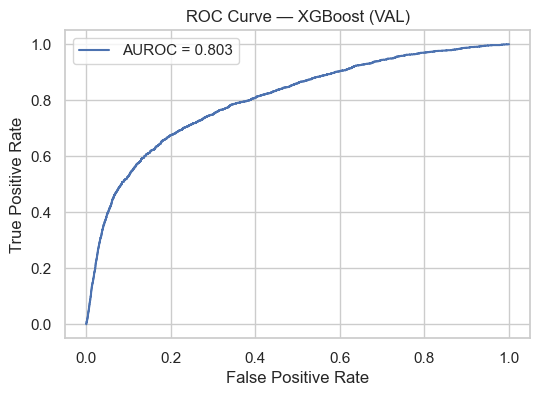

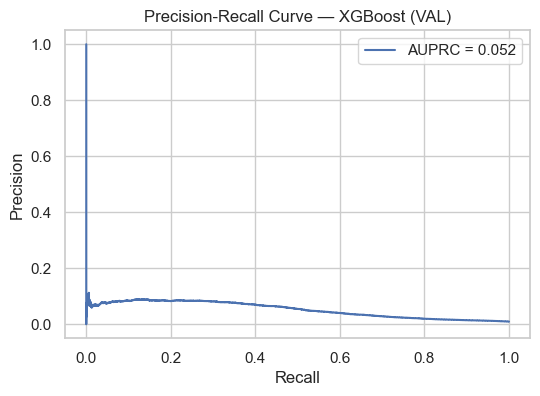

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_val, xgb_results_val["probs"])
ax.plot(fpr_xgb, tpr_xgb, label=f"AUROC = {xgb_results_val['auroc']:.3f}")
ax.set_title("ROC Curve — XGBoost (VAL)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
EXPORTED_FIGURES.append(("03_xgb_roc_val", fig))
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
precision_xgb, recall_xgb, _ = metrics.precision_recall_curve(y_val, xgb_results_val["probs"])
ax.plot(recall_xgb, precision_xgb, label=f"AUPRC = {xgb_results_val['auprc']:.3f}")
ax.set_title("Precision-Recall Curve — XGBoost (VAL)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
EXPORTED_FIGURES.append(("03_xgb_pr_val", fig))
plt.show()


XGBoost substantially outperformed both logistic regression and random forest.
Its AUROC exceeded 0.80 on both validation and test sets, indicating strong
discrimination between patients who will and will not develop sepsis within the
next six hours. The model also achieved the highest AUPRC (0.052), which is
notable given the extremely low prevalence of positive labels and corresponds
to more than five times the random baseline. Unlike the previous baselines,
XGBoost produced a non-zero F1 score, demonstrating that it began to identify
positive cases rather than defaulting to the majority class. The decrease in
accuracy reflects this desirable shift and highlights the inadequacy of accuracy
as an evaluation metric in highly imbalanced clinical risk prediction.


## Step 12 — Baseline model comparison (LogReg, RF, XGBoost)

In [18]:
metrics_rows = []

def add_to_metrics(model_name: str, res: dict):
    metrics_rows.append({
        "model": model_name,
        "split": res["split"],
        "auroc": res["auroc"],
        "auprc": res["auprc"],
        "f1": res["f1"],
        "acc": res["acc"],
    })

# Logistic Regression (stored earlier as results_val / results_test)
add_to_metrics("logreg", results_val)
add_to_metrics("logreg", results_test)

# Random Forest
add_to_metrics("random_forest", rf_results_val)
add_to_metrics("random_forest", rf_results_test)

# XGBoost
add_to_metrics("xgboost", xgb_results_val)
add_to_metrics("xgboost", xgb_results_test)

metrics_df = pd.DataFrame(metrics_rows)
display(metrics_df)

,model,split,auroc,auprc,f1,acc
0,logreg,VAL,0.759054,0.045561,0.050930,0.779318
1,logreg,TEST,0.763779,0.042405,0.049068,0.783763
2,random_forest,VAL,0.769968,0.049031,0.000000,0.990456
3,random_forest,TEST,0.792511,0.044287,0.000000,0.991185
4,xgboost,VAL,0.803169,0.052104,0.074034,0.855175
5,xgboost,TEST,0.804823,0.045339,0.066870,0.854986


The three baseline models show a clear performance hierarchy. Logistic
regression provides a reasonable starting point, but is limited by its
assumption of linear decision boundaries. Random Forest improves AUROC
and AUPRC through nonlinear splits, yet remains overly conservative and
rarely predicts the positive class. XGBoost delivers the best overall
performance, achieving AUROC above 0.80 on both validation and test
sets and the highest AUPRC. It is also the first model to produce a
non-zero F1 score, indicating that it has learned to identify positive
cases rather than defaulting to the negative majority class. These
results confirm that the engineered temporal features contain meaningful
predictive signal and that gradient boosting is an effective baseline
for early sepsis prediction.


## Step 13 — Export baseline results and figures

In [19]:
# Export per-hour risk trajectories for baseline models
# Probabilities for all TRAIN+VAL rows (same order as train_model_df)
logreg_train_probs = logreg_pipeline.predict_proba(X_train_full)[:, 1]
rf_train_probs = rf_pipeline.predict_proba(X_train_full)[:, 1]
xgb_train_probs = xgb_model.predict_proba(X_train_full)[:, 1]

train_traj_base = train_model_df[[PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL]].copy()
train_traj_base["risk_logreg"] = logreg_train_probs
train_traj_base["risk_rf"] = rf_train_probs
train_traj_base["risk_xgb_base"] = xgb_train_probs

split_flag = np.where(train_mask_inner, "train", "val")
train_traj_base["split_03"] = split_flag

# TEST trajectories
logreg_test_probs = logreg_pipeline.predict_proba(X_test)[:, 1]
rf_test_probs = rf_pipeline.predict_proba(X_test)[:, 1]
xgb_test_probs = xgb_model.predict_proba(X_test)[:, 1]

test_traj_base = test_model_df[[PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL]].copy()
test_traj_base["risk_logreg"] = logreg_test_probs
test_traj_base["risk_rf"] = rf_test_probs
test_traj_base["risk_xgb_base"] = xgb_test_probs
test_traj_base["split_03"] = "test"

# Save one file per model so Notebook 06 can treat them separately
train_logreg_path = RESULTS_THIS / "03_logreg_risk_trajectories_trainval.csv"
test_logreg_path = RESULTS_THIS / "03_logreg_risk_trajectories_test.csv"

train_rf_path = RESULTS_THIS / "03_rf_risk_trajectories_trainval.csv"
test_rf_path = RESULTS_THIS / "03_rf_risk_trajectories_test.csv"

train_xgb_path = RESULTS_THIS / "03_xgb_risk_trajectories_trainval.csv"
test_xgb_path = RESULTS_THIS / "03_xgb_risk_trajectories_test.csv"

train_traj_base[[PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL, "risk_logreg", "split_03"]] \
    .to_csv(train_logreg_path, index=False)
test_traj_base[[PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL, "risk_logreg", "split_03"]] \
    .to_csv(test_logreg_path, index=False)

train_traj_base[[PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL, "risk_rf", "split_03"]] \
    .to_csv(train_rf_path, index=False)
test_traj_base[[PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL, "risk_rf", "split_03"]] \
    .to_csv(test_rf_path, index=False)

train_traj_base[[PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL, "risk_xgb_base", "split_03"]] \
    .to_csv(train_xgb_path, index=False)
test_traj_base[[PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL, "risk_xgb_base", "split_03"]] \
    .to_csv(test_xgb_path, index=False)

print("Saved baseline risk trajectories to:")
print("  LOGREG train/val:", train_logreg_path)
print("  LOGREG test     :", test_logreg_path)
print("  RF     train/val:", train_rf_path)
print("  RF     test     :", test_rf_path)
print("  XGB    train/val:", train_xgb_path)
print("  XGB    test     :", test_xgb_path)


Saved baseline risk trajectories to:
  LOGREG train/val: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\03_feature_engineering_baselines\03_logreg_risk_trajectories_trainval.csv
  LOGREG test     : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\03_feature_engineering_baselines\03_logreg_risk_trajectories_test.csv
  RF     train/val: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\03_feature_engineering_baselines\03_rf_risk_trajectories_trainval.csv
  RF     test     : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\03_feature_engineering_baselines\03_rf_risk_trajectories_test.csv
  XGB    train/val: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\03_feature_engineering_baselines\03_xgb_risk_trajectories_trainval.csv
  XGB    test     : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\03_feature_engineering_baselines\03_xgb_risk_trajectories_test.csv


In [20]:
# Save comparison table (metrics_df must be defined from Step 12)
metrics_path = RESULTS_THIS / "03_baseline_model_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)
print("Saved baseline comparison metrics to:", metrics_path)

# Export all figures collected during modeling
for name, fig in EXPORTED_FIGURES:
    out_path = FIGURES_THIS / f"{name}.png"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    print("Saved figure:", out_path)

print("\nAll figures successfully exported.")

Saved baseline comparison metrics to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\03_feature_engineering_baselines\03_baseline_model_metrics.csv
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\03_feature_engineering_baselines\03_logreg_roc_val.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\03_feature_engineering_baselines\03_logreg_pr_val.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\03_feature_engineering_baselines\03_rf_roc_val.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\03_feature_engineering_baselines\03_rf_pr_val.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\03_feature_engineering_baselines\03_xgb_roc_val.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\03_feature_engineering_baselines\03_xgb_pr_val.png

All figures successfully exporte